In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

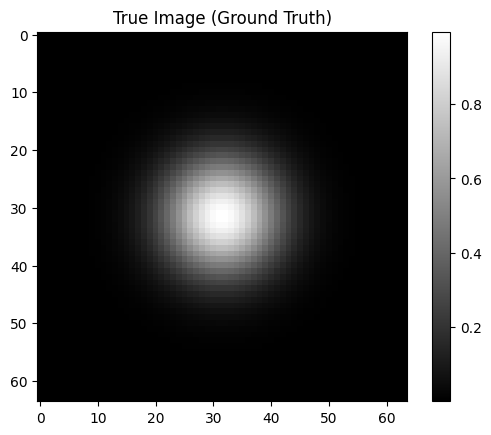

In [7]:
# Create a synthetic "true image" - A circle in a 64x64 grid
def generate_true_image(size=64):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    true_image = np.exp(-10 * (x**2 + y**2))  # Creates a Gaussian-like blob
    return true_image

# Generate and visualize the true image
true_image = generate_true_image()

plt.imshow(true_image, cmap='gray')
plt.title("True Image (Ground Truth)")
plt.colorbar()
plt.show()

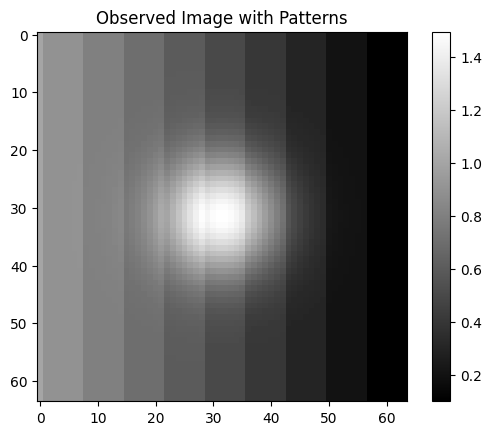

In [8]:
# Step 2: Initialize with noisy version of true image
def generate_scale_bar(size=64, num_levels=10):
    """
    Generate a gradient layer with high values at the top and low values at the bottom.
    The gradient is discretized into a specified number of levels to create visible steps.
    """
    # Create a linear gradient from high to low
    scale_layer = np.linspace(1, 0, size)  # Linear gradient from 1 to 0
    scale_layer = np.tile(scale_layer, (size, 1))  # Repeat to create 2D layer
    # Discretize the gradient into `num_levels` discrete steps
    scale_layer_discrete = np.digitize(scale_layer, bins=np.linspace(0, 1, num_levels))  # Bin values into levels
    # Normalize back to a range [0, 1] (if needed for visual consistency)
    scale_layer_discrete = scale_layer_discrete / num_levels
    
    return scale_layer_discrete

obs_image = true_image + generate_scale_bar()

# Visualize the noisy image
plt.imshow(obs_image, cmap="gray")
plt.title("Observed Image with Patterns")
plt.colorbar()
plt.show()

In [9]:
# Variational Inference Model
class VariationalInference(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.image_size = image_size
        self.mu = nn.Parameter(torch.zeros(image_size))
        self.log_var = nn.Parameter(torch.zeros(image_size))
    
    def forward(self):
        q_distribution = dist.Normal(self.mu, torch.exp(0.5 * self.log_var))
        return q_distribution

In [64]:
def train_vi(noisy_image, num_epochs=1000, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    noisy_image_tensor = torch.tensor(noisy_image, dtype=torch.float).to(device)
    image_size = noisy_image_tensor.shape
    vi_model = VariationalInference(image_size).to(device)
    optimizer = optim.Adam(vi_model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        q_distribution = vi_model()
        sampled_image = q_distribution.rsample()
        
        # Log-Likelihood (L2 loss term)
        log_likelihood = -0.5 * torch.sum((sampled_image - noisy_image_tensor) ** 2)
        
        # KL Divergence Regularization (from normal distribution)
        kl_div = torch.sum(dist.kl_divergence(q_distribution, dist.Normal(0, 1)))
        
        # Total loss
        loss = -log_likelihood + 0.01 * kl_div
        
        loss.backward()
        optimizer.step()
        
        if epoch % 5000 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return vi_model


Epoch 0: Loss = 2894.8162
Epoch 5000: Loss = 1956.2343
Epoch 10000: Loss = 1312.3312
Epoch 15000: Loss = 972.1620
Epoch 20000: Loss = 721.6534
Epoch 25000: Loss = 566.5624
Epoch 30000: Loss = 460.4978
Epoch 35000: Loss = 352.5577
Epoch 40000: Loss = 279.4376
Epoch 45000: Loss = 237.3327
Epoch 50000: Loss = 186.5652
Epoch 55000: Loss = 163.7621
Epoch 60000: Loss = 141.5989
Epoch 65000: Loss = 131.3087
Epoch 70000: Loss = 120.4980
Epoch 75000: Loss = 116.6927
Epoch 80000: Loss = 110.6265
Epoch 85000: Loss = 107.1576
Epoch 90000: Loss = 105.7429
Epoch 95000: Loss = 103.9977


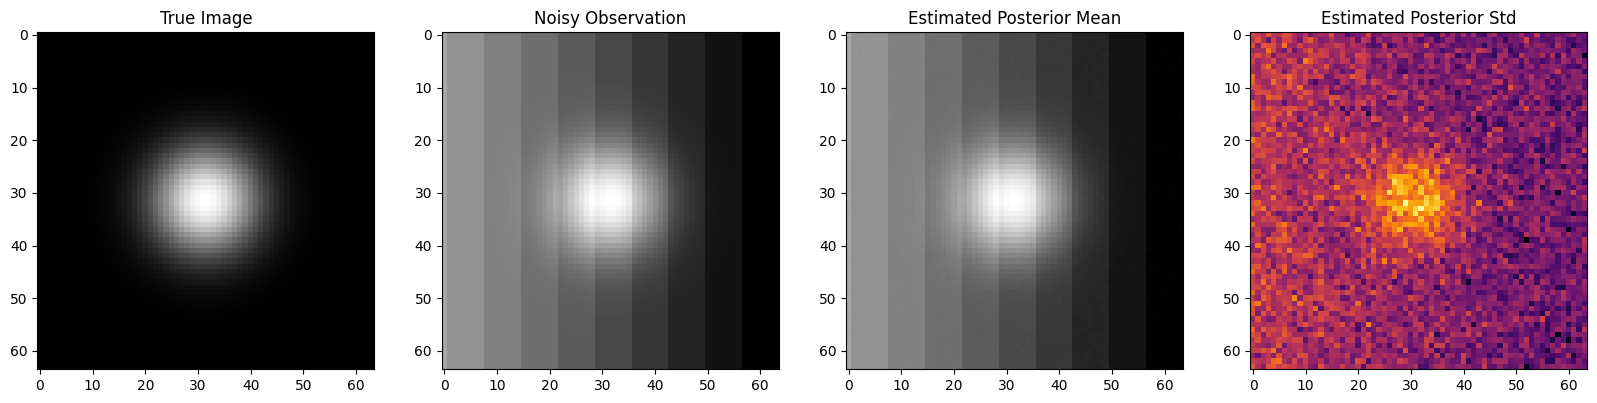

In [65]:
# After training:
trained_vi_model = train_vi(obs_image, num_epochs=100000, lr=0.0001)

# Extract mean and std
posterior_mean = trained_vi_model.mu.data.cpu().numpy()  # Convert to NumPy array (if needed)
posterior_variance = torch.exp(trained_vi_model.log_var.data).cpu().numpy()

# print("Posterior Mean:", posterior_mean)
# print("Posterior Std:", posterior_std)

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(true_image, cmap='gray')
axes[0].set_title("True Image")
axes[1].imshow(obs_image, cmap='gray')
axes[1].set_title("Noisy Observation")
axes[2].imshow(posterior_mean, cmap='gray')
axes[2].set_title("Estimated Posterior Mean")
axes[3].imshow(posterior_variance, cmap='inferno')
axes[3].set_title("Estimated Posterior Std")
plt.show()
